In [1]:
import numpy as np
import pandas as pd
import scipy.stats as sps
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

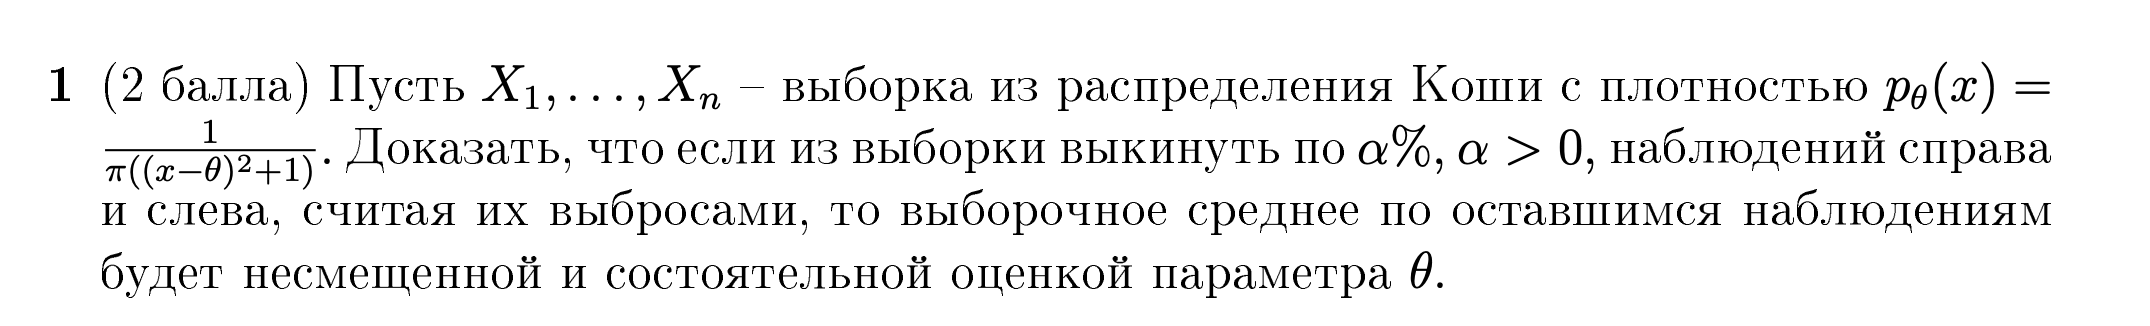

Сначала законспектируем факт - речь идет об усеченном среднем

Начнем с простой части - с доказательства состоятельности

В курсе ДС-потока у нас б/д была вот такая теорема - из нее очевидно(по определению) следует асимптотическая нормальность оценки откуда следует состоятельность 

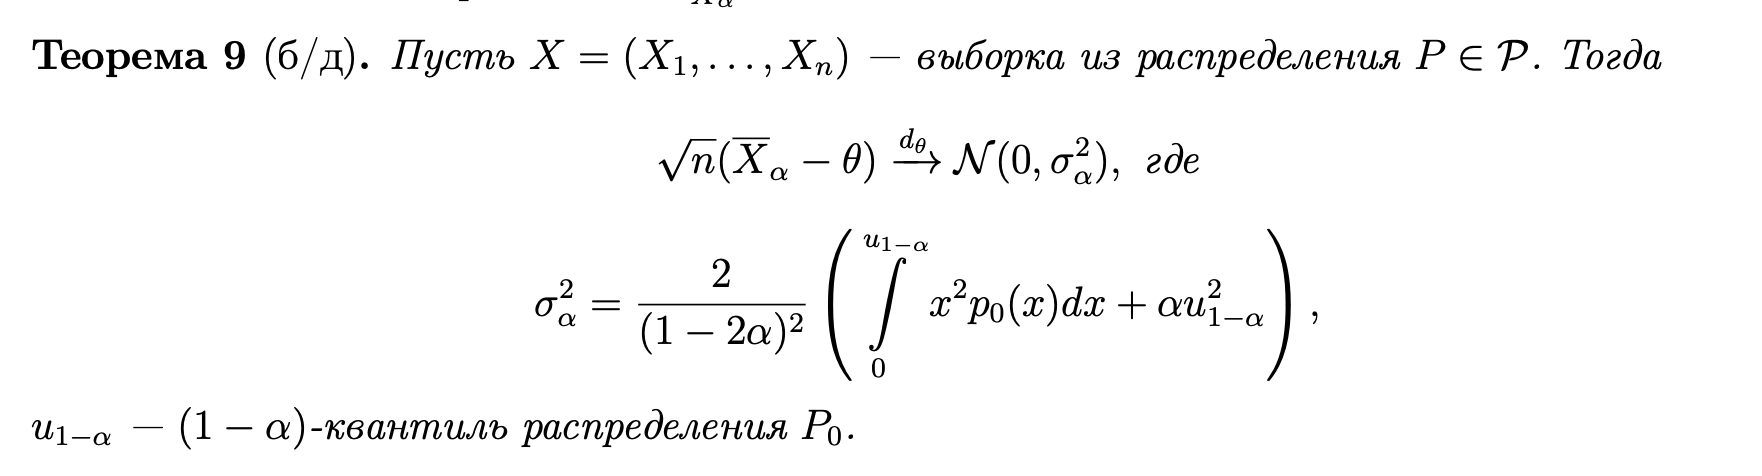

Теперь к сложной части - доказательству несмещенности

Во-первых: запишем усеченное среднее

$X̅_{\alpha} = \frac{1}{n - 2*m}\sum_{i=m+1}^{n-m}X_{(i)}, m = ⌈(n-1)\alpha⌉$

- Заметим что распределение Коши симметрично от-но параметра location - $\theta$. Tо есть $p_{\theta, 1}(x) = p_{\theta,1}(2\theta - x)$

- 



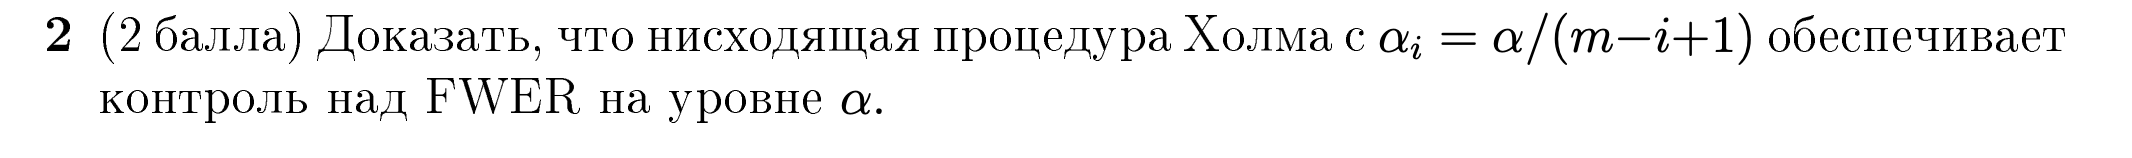

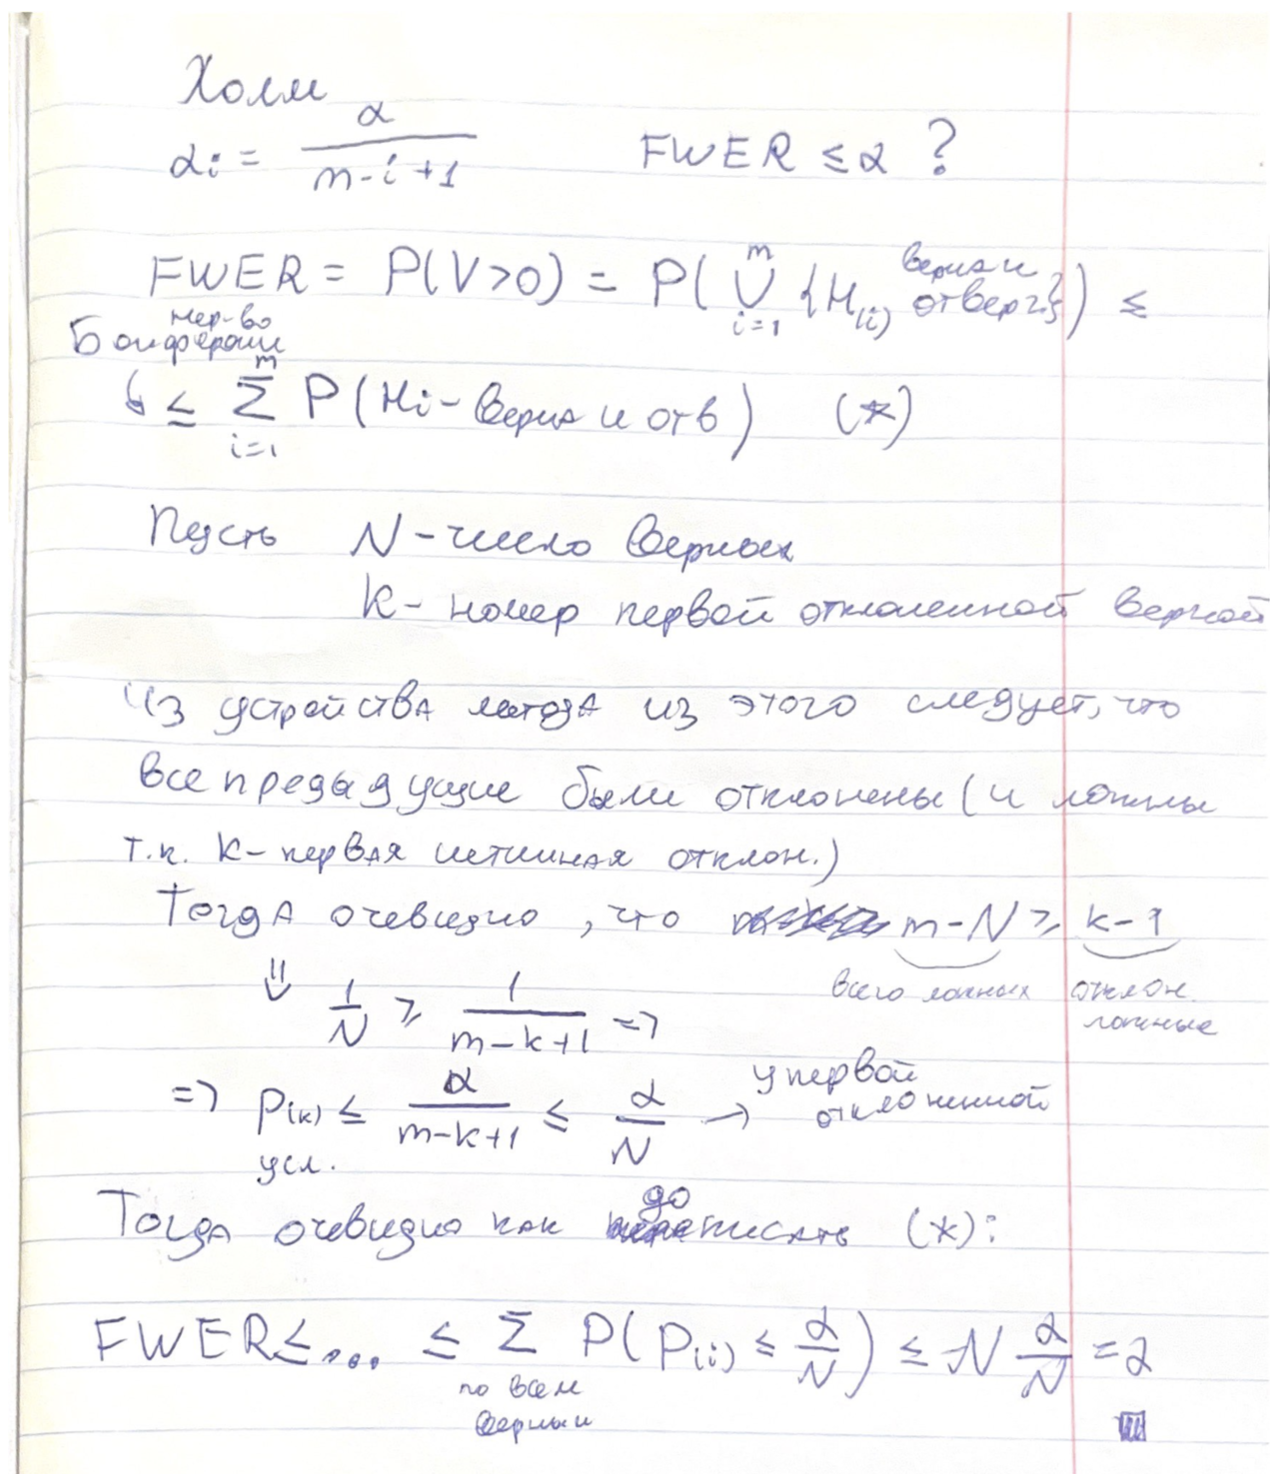

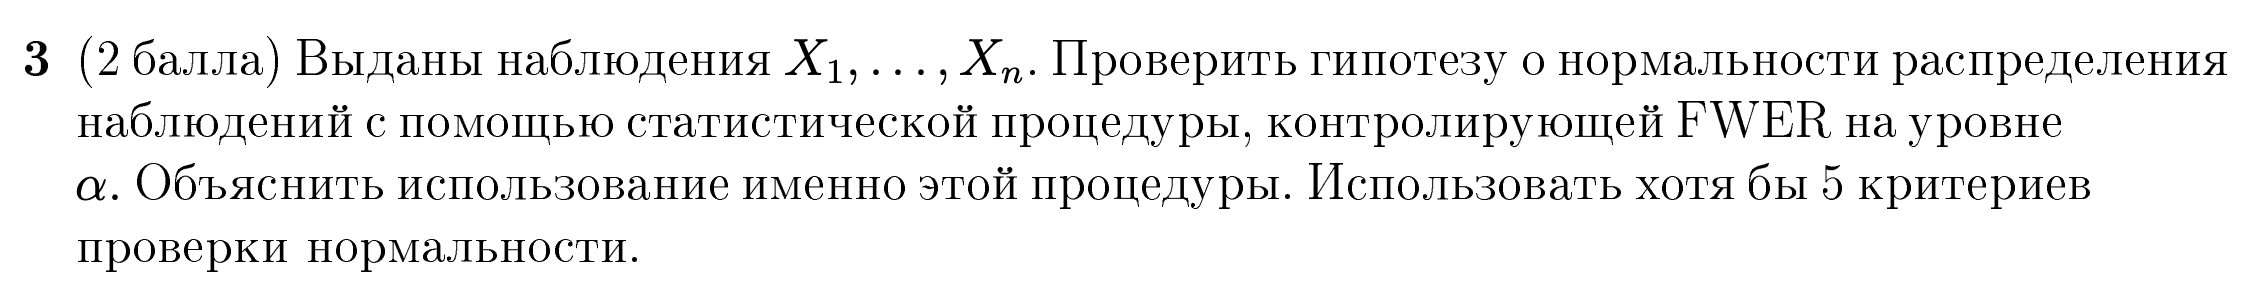

In [23]:
# ds
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data"
columns = [
            'Alcohol',
            'Malic acid',
            'Ash',
            'Alcalinity of ash',
            'Magnesium',
            'Total phenols',
            'Flavanoids',
            'Nonflavanoid phenols',
            'Proanthocyanins',
            'Color intensity',
            'Hue',
            'OD280/OD315 of diluted wines',
            'Proline'
          ]
data = pd.read_csv(url, header=None, names=columns)
data.head(10)

,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735
1,14.20,1.76,2.45,15.2,112,3.27,3.39,0.34,1.97,6.75,1.05,2.85,1450
1,14.39,1.87,2.45,14.6,96,2.50,2.52,0.30,1.98,5.25,1.02,3.58,1290
1,14.06,2.15,2.61,17.6,121,2.60,2.51,0.31,1.25,5.05,1.06,3.58,1295
1,14.83,1.64,2.17,14.0,97,2.80,2.98,0.29,1.98,5.20,1.08,2.85,1045
1,13.86,1.35,2.27,16.0,98,2.98,3.15,0.22,1.85,7.22,1.01,3.55,1045


In [24]:
sample = data['Ash'].to_numpy()
len(sample)

178

Я возьму критерии Жарка-Бера, Шапиро-Уилка, тест типа Харке-Бера, Лиллиефорса и Андерсона-Дарлинга

Думаю что стоит применить метод Холма так как он обеспечивает FWER <= $\alpha$ при любых зависимостях $p_i$

Отклоним гипотезу о нормальности если **хотя б на 1** из критериев дадут $p_{val} > \alpha$

Если нормальность не отклоняется, считаем, что выборка согласуется с основной гипотезой

In [25]:
from statsmodels.stats.diagnostic import lilliefors
from statsmodels.stats.diagnostic import normal_ad

# Полсчет p_value для критериев
pval_jb = sps.jarque_bera(sample)[1]
pval_sh = sps.shapiro(sample)[1]
pval_normaltest = sps.normaltest(sample)[1]
pval_lil = lilliefors(sample)[1]
pval_ad = normal_ad(sample)[1]

p_vals = [pval_jb, pval_sh, pval_normaltest, pval_lil, pval_ad]

Воспользуемся готовой функцией multipletests

In [26]:
from statsmodels.sandbox.stats.multicomp import multipletests

rejects, mpt_dt, _, _ = multipletests(p_vals, method='holm')

In [27]:
rejects

array([ True, False, False, False, False])

> true for hypothesis that can be rejected for given alpha

Это из документации. получается метод Холма отвергает только первую, что соответвует критерию нормальности теста харке-бера

Но меня очень смущает что отклонился только тот критерий, который не советуют использовать на малых выборках - поэтому пожалуй я заменю его на что то иное



In [46]:
# Полсчет p_value для критериев
pval_sh = sps.shapiro(sample)[1]
pval_normaltest = sps.normaltest(sample)[1]
pval_lil = lilliefors(sample)[1]
pval_ad = normal_ad(sample)[1]

params = sps.fit(sps.norm, sample, bounds=[(-7, 7), (0.1, 10)]).params
pval_cram = sps.cramervonmises(sample, cdf=sps.norm(*params).cdf).pvalue

p_vals = [pval_sh, pval_normaltest, pval_lil, pval_ad, pval_cram]

In [47]:
rejects, mpt_dt, _, _ = multipletests(p_vals, method='holm')

In [48]:
rejects

array([False, False, False, False, False])

Ура-Ура!!

Но давайте посмотрим на скорректированные p_value 

In [49]:
mpt_dt

array([0.1815801 , 0.1815801 , 0.37300821, 0.22563953, 0.59612182])

In [50]:
(mpt_dt < 0.05)

array([False, False, False, False, False])

Действительно - те же результаты. Получается мы не отвергли ни одной гипотезы - значит смело можем принять гипотезу о нормальности выборки - ниже Q-Q-plot

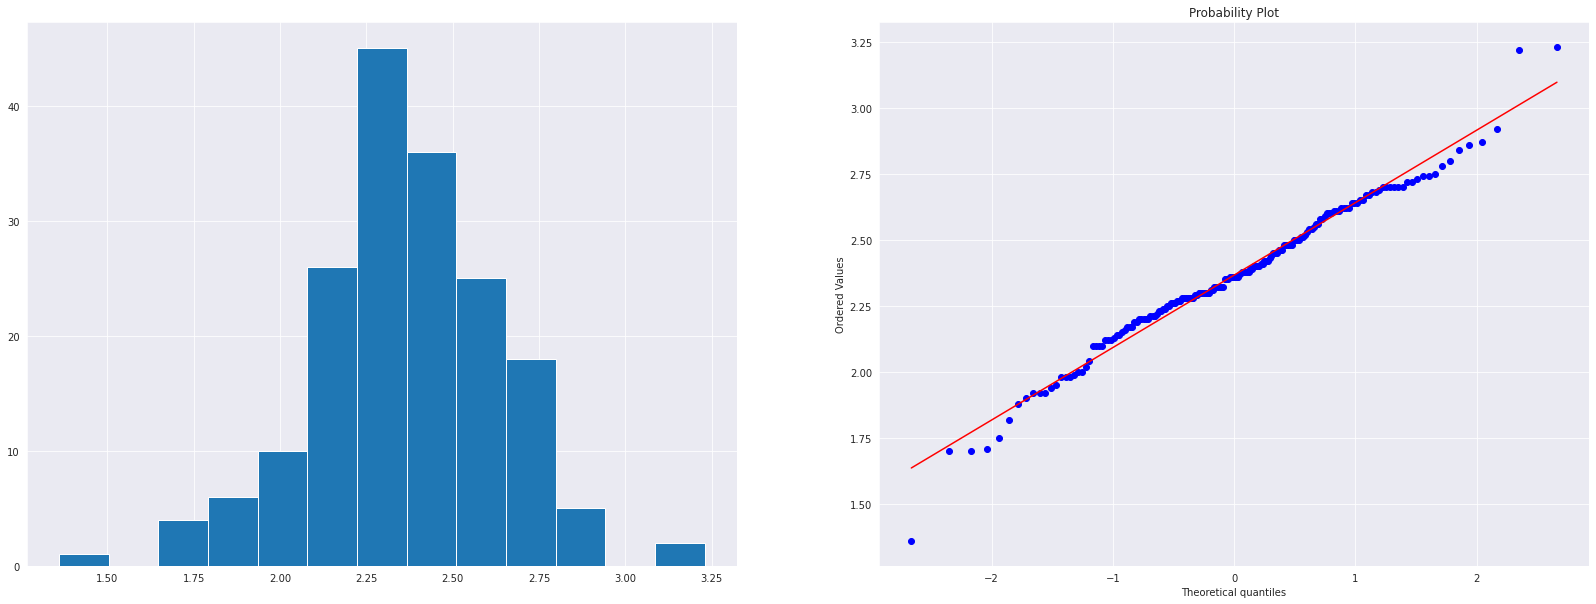

In [51]:
with sns.axes_style('darkgrid'):
  plt.figure(figsize=(28, 10))
  plt.subplot(1, 2, 1)
  plt.hist(sample, bins=13)

  plt.subplot(1, 2, 2)
  sps.probplot(x=sample, plot=plt)

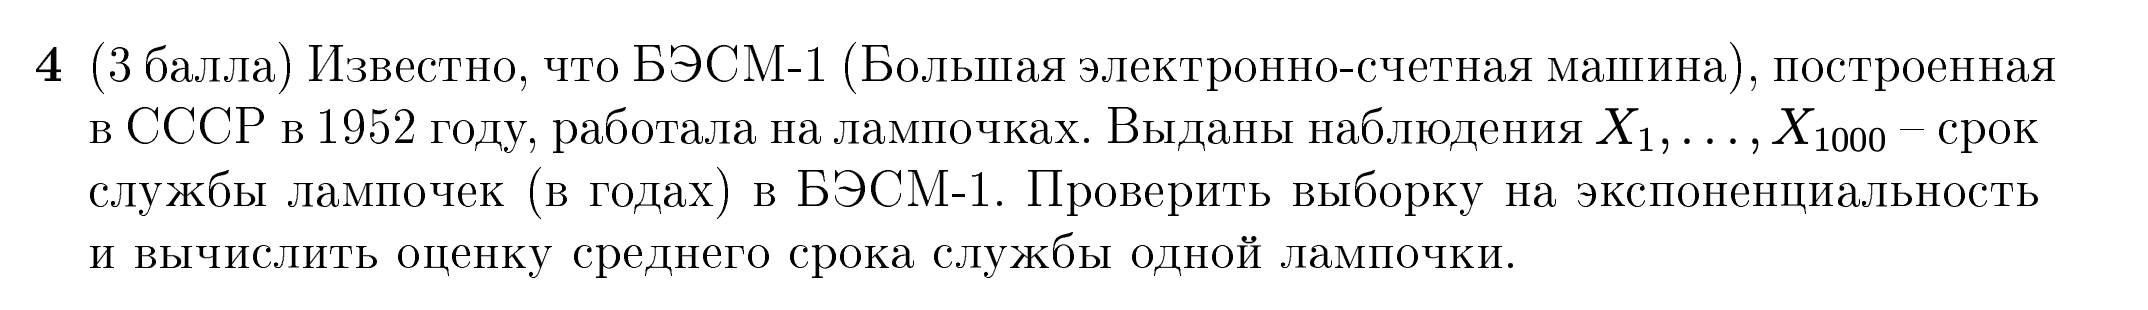

In [53]:
data = np.load('hw4t4.npy')
len(data)

1000

Начнем как обычно с визуального анализа - гистограмма и боксплот чтоб посмотреть присутствие выбросов

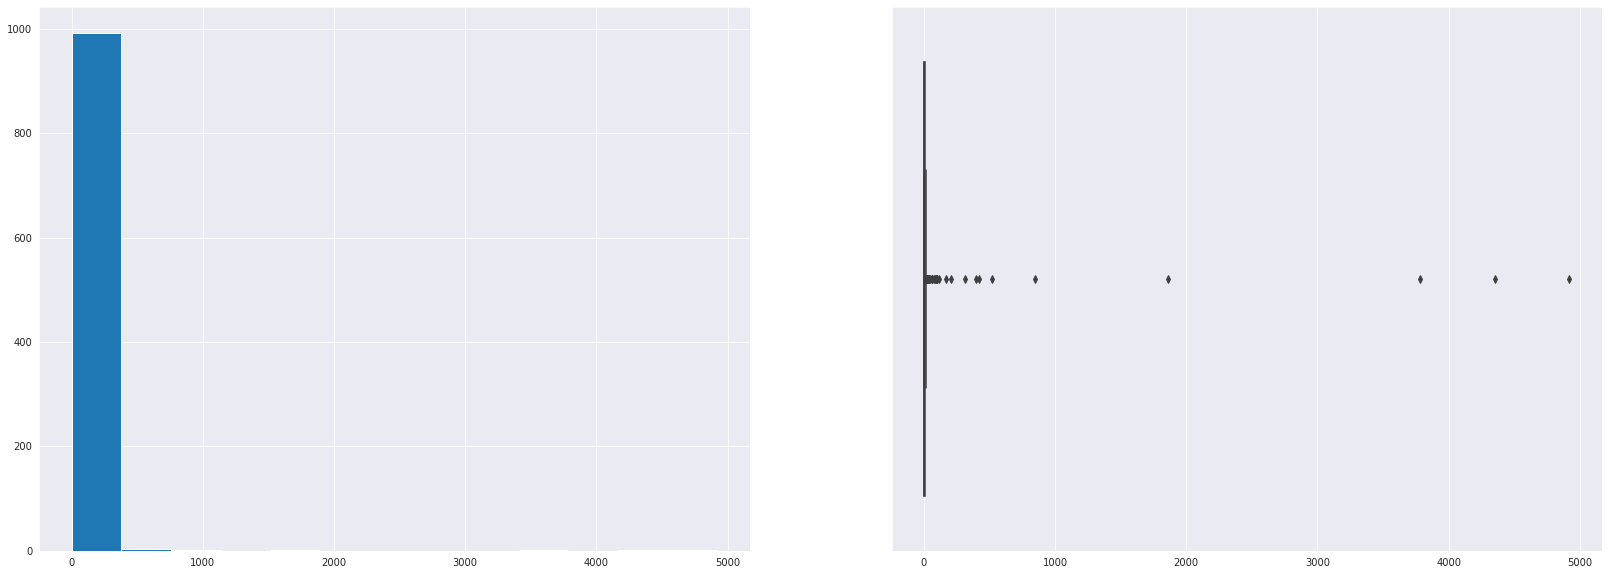

In [64]:
with sns.axes_style('darkgrid'):
  plt.figure(figsize=(28, 10))
  plt.subplot(1, 2, 1)
  plt.hist(data, bins=13)

  plt.subplot(1, 2, 2)
  sns.boxplot(x=data)

In [60]:
data.mean(), np.median(data), data.max(), data.min()

(23.094988807180062,
 2.840914876220757,
 4920.797509006718,
 0.0022997621116264506)

То есть при среднем значении в 23 с чем-то мы получаем медиану в районе трех

При этом максимальное значение срока службы лампочек - 4920 - неплохо там тусили древние греки.

Да и по гистограмме понятно ~~и теме семинара~~ что нужно поработать с выбросами, которые здесь явно присутствуют

Применим Isolation forest с лекции

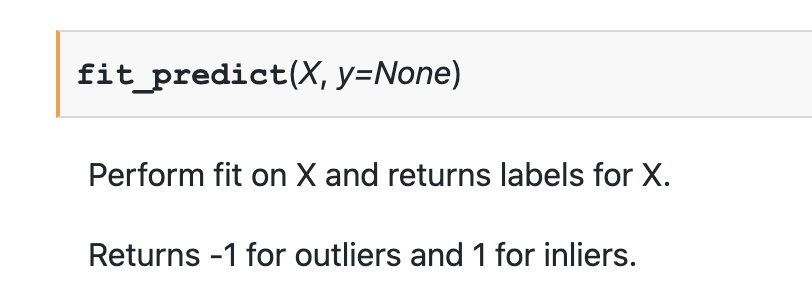


In [61]:
from sklearn.ensemble import IsolationForest

X = data[:, np.newaxis]
pred = IsolationForest(random_state=0).fit_predict(X)

sample = data[pred == 1]
len(sample)

934

Получается выкинули всего 66 элементов - посмотрим как это повлияло

In [62]:
sample.mean(), np.median(sample), sample.max(), sample.min()

(3.71018472971064,
 2.6172449142990675,
 14.27255544550281,
 0.0022997621116264506)

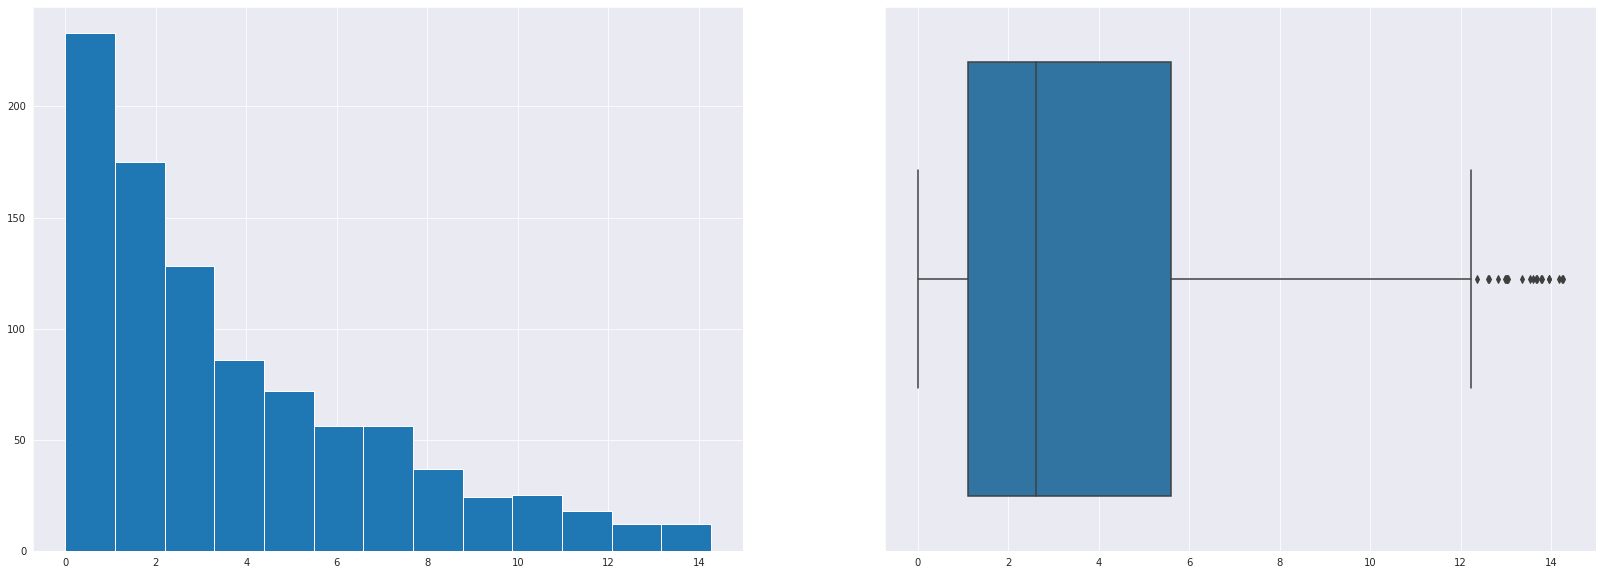

In [65]:
with sns.axes_style('darkgrid'):
  plt.figure(figsize=(28, 10))
  plt.subplot(1, 2, 1)
  plt.hist(sample, bins=13)

  plt.subplot(1, 2, 2)
  sns.boxplot(x=sample)

Уже что то похожее на правду

Возьму критерий Лиллиефорса для проверки Экспоненциальности

In [82]:
pval_lil = lilliefors(sample, dist='exp')[1]

In [83]:
pval_lil < 0.05

True

Че-то у меня ничего не вышло - попробуем применть правило из аналитики и выкинутиь всего 5% данных а не 6.6%

In [74]:
sample_sorted = np.sort(data)

sample_95 = sample_sorted[:950]
len(sample_95)

950

In [76]:
sample_95.mean(), np.median(sample_95), sample_95.max(), sample_95.min()

(3.9076546592780685,
 2.667041765451591,
 16.49918892314538,
 0.0022997621116264506)

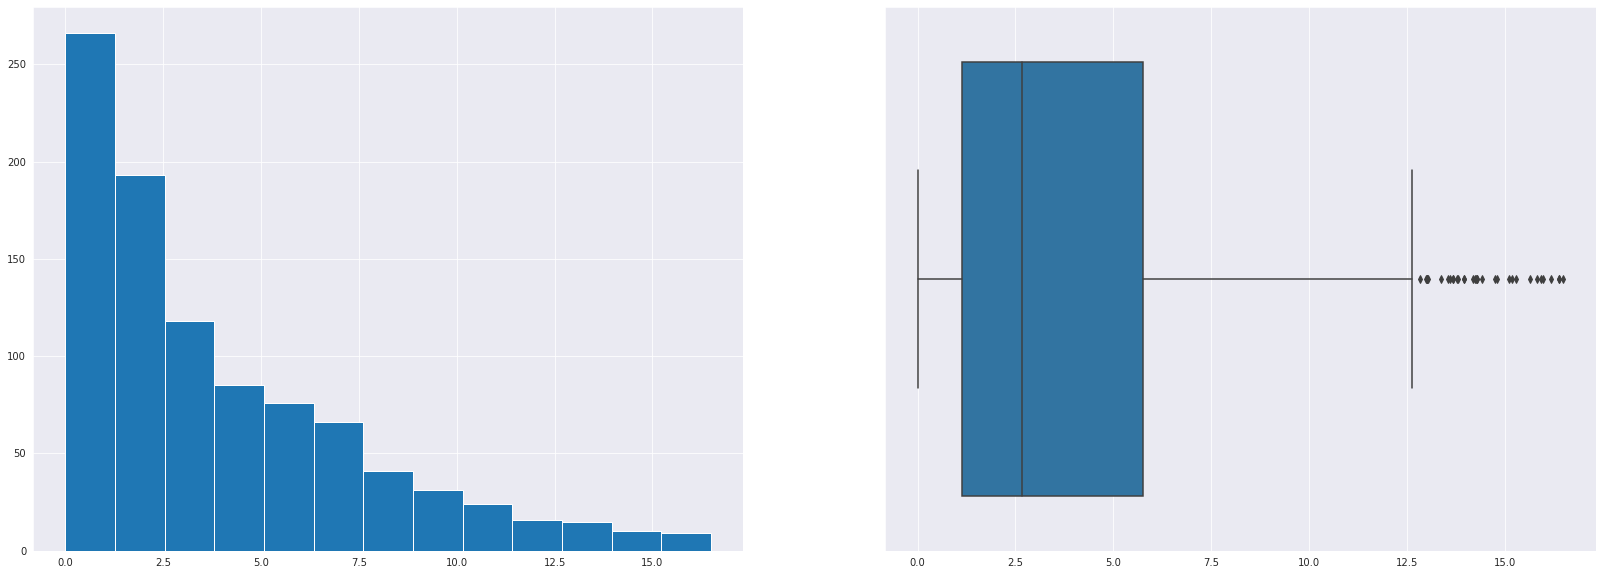

In [77]:
with sns.axes_style('darkgrid'):
  plt.figure(figsize=(28, 10))
  plt.subplot(1, 2, 1)
  plt.hist(sample_95, bins=13)

  plt.subplot(1, 2, 2)
  sns.boxplot(x=sample_95)

In [78]:
pval_lil = lilliefors(sample_95, dist='exp')[1]

In [81]:
pval_lil < 0.05

False

Ура - получается не отклоняем гипотезу об экспоненциальности!

Вычислим оценку среднего срока службы одной лампы

Искомая величина - единица делить на параметр экпоненциального распределения (так как матож), а так как мы знаем, что среднее это оценка данной штуки - то искомая величина это среднее по выборке

In [84]:
sample_95.mean()

3.9076546592780685

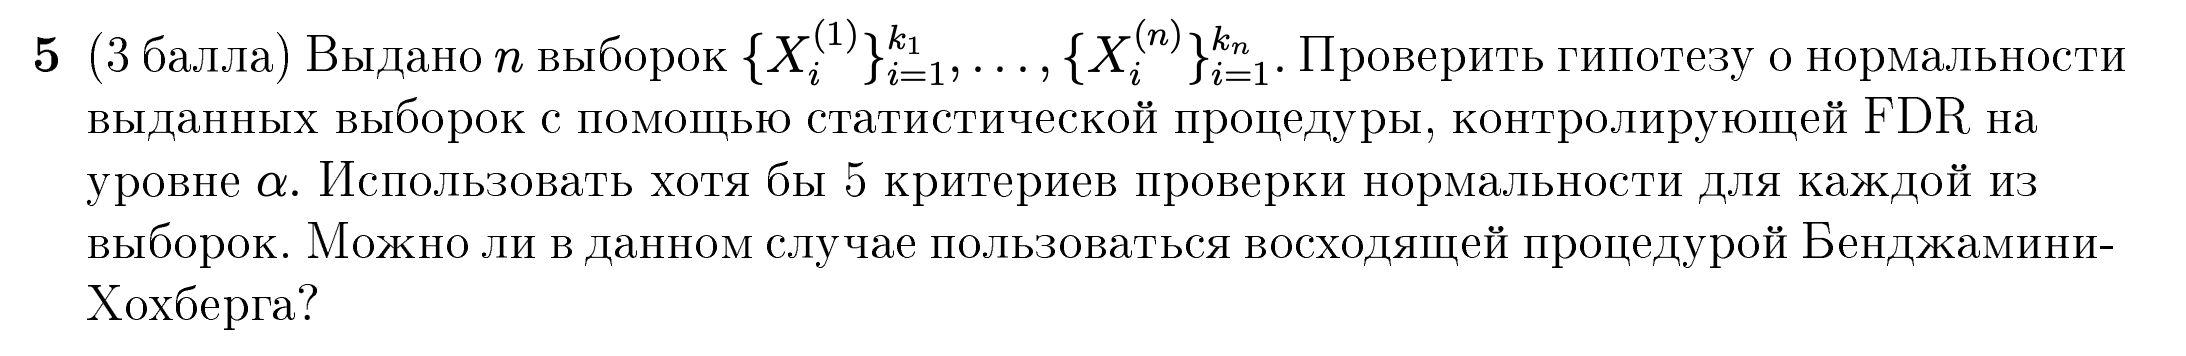

In [97]:
url = "http://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data"
columns = [
            'Sex',
            'Length',
            'Diameter',
            'Height',
            'Whole weight',
            'Shucked weight',
            'Viscera weight',
            'Shell weight',
            'Rings',
          ]
data_abalone = pd.read_csv(url, header=None, names=columns)
data_abalone.head()

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [96]:
data_tracks = pd.read_csv('go_track_tracks.csv')
data.head()

,id,id_android,speed,time,distance,rating,rating_bus,rating_weather,car_or_bus,linha
0,1,0,19.210586,0.138049,2.652,3,0,0,1,NaN
1,2,0,30.848229,0.171485,5.290,3,0,0,1,NaN
2,3,1,13.560101,0.067699,0.918,3,0,0,2,NaN
3,4,1,19.766679,0.389544,7.700,3,0,0,2,NaN
4,8,0,25.807401,0.154801,3.995,2,0,0,1,NaN


In [98]:
# ds
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data"
columns = [
            'Alcohol',
            'Malic acid',
            'Ash',
            'Alcalinity of ash',
            'Magnesium',
            'Total phenols',
            'Flavanoids',
            'Nonflavanoid phenols',
            'Proanthocyanins',
            'Color intensity',
            'Hue',
            'OD280/OD315 of diluted wines',
            'Proline'
          ]
data_wine = pd.read_csv(url, header=None, names=columns)
data_wine.head(10)

,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735
1,14.20,1.76,2.45,15.2,112,3.27,3.39,0.34,1.97,6.75,1.05,2.85,1450
1,14.39,1.87,2.45,14.6,96,2.50,2.52,0.30,1.98,5.25,1.02,3.58,1290
1,14.06,2.15,2.61,17.6,121,2.60,2.51,0.31,1.25,5.05,1.06,3.58,1295
1,14.83,1.64,2.17,14.0,97,2.80,2.98,0.29,1.98,5.20,1.08,2.85,1045
1,13.86,1.35,2.27,16.0,98,2.98,3.15,0.22,1.85,7.22,1.01,3.55,1045


In [99]:
samples = [
    data_abalone['Shucked weight'],
    data_abalone['Viscera weight'],
    data_abalone['Shell weight'],
    data_tracks['speed'],
    data_tracks['distance'],
    data_wine['Alcohol'],
    data_wine['Ash'],
    data_wine['Nonflavanoid phenols'],
    data_wine['Proanthocyanins']
]

In [101]:
samples_names = [
    'Shucked weight',
    'Viscera weight',
    'Shell weight',
    'speed',
    'distance',
    'Alcohol',
    'Ash',
    'Nonflavanoid phenols',
    'Proanthocyanins'
]

Нарисуем Q-Q plots

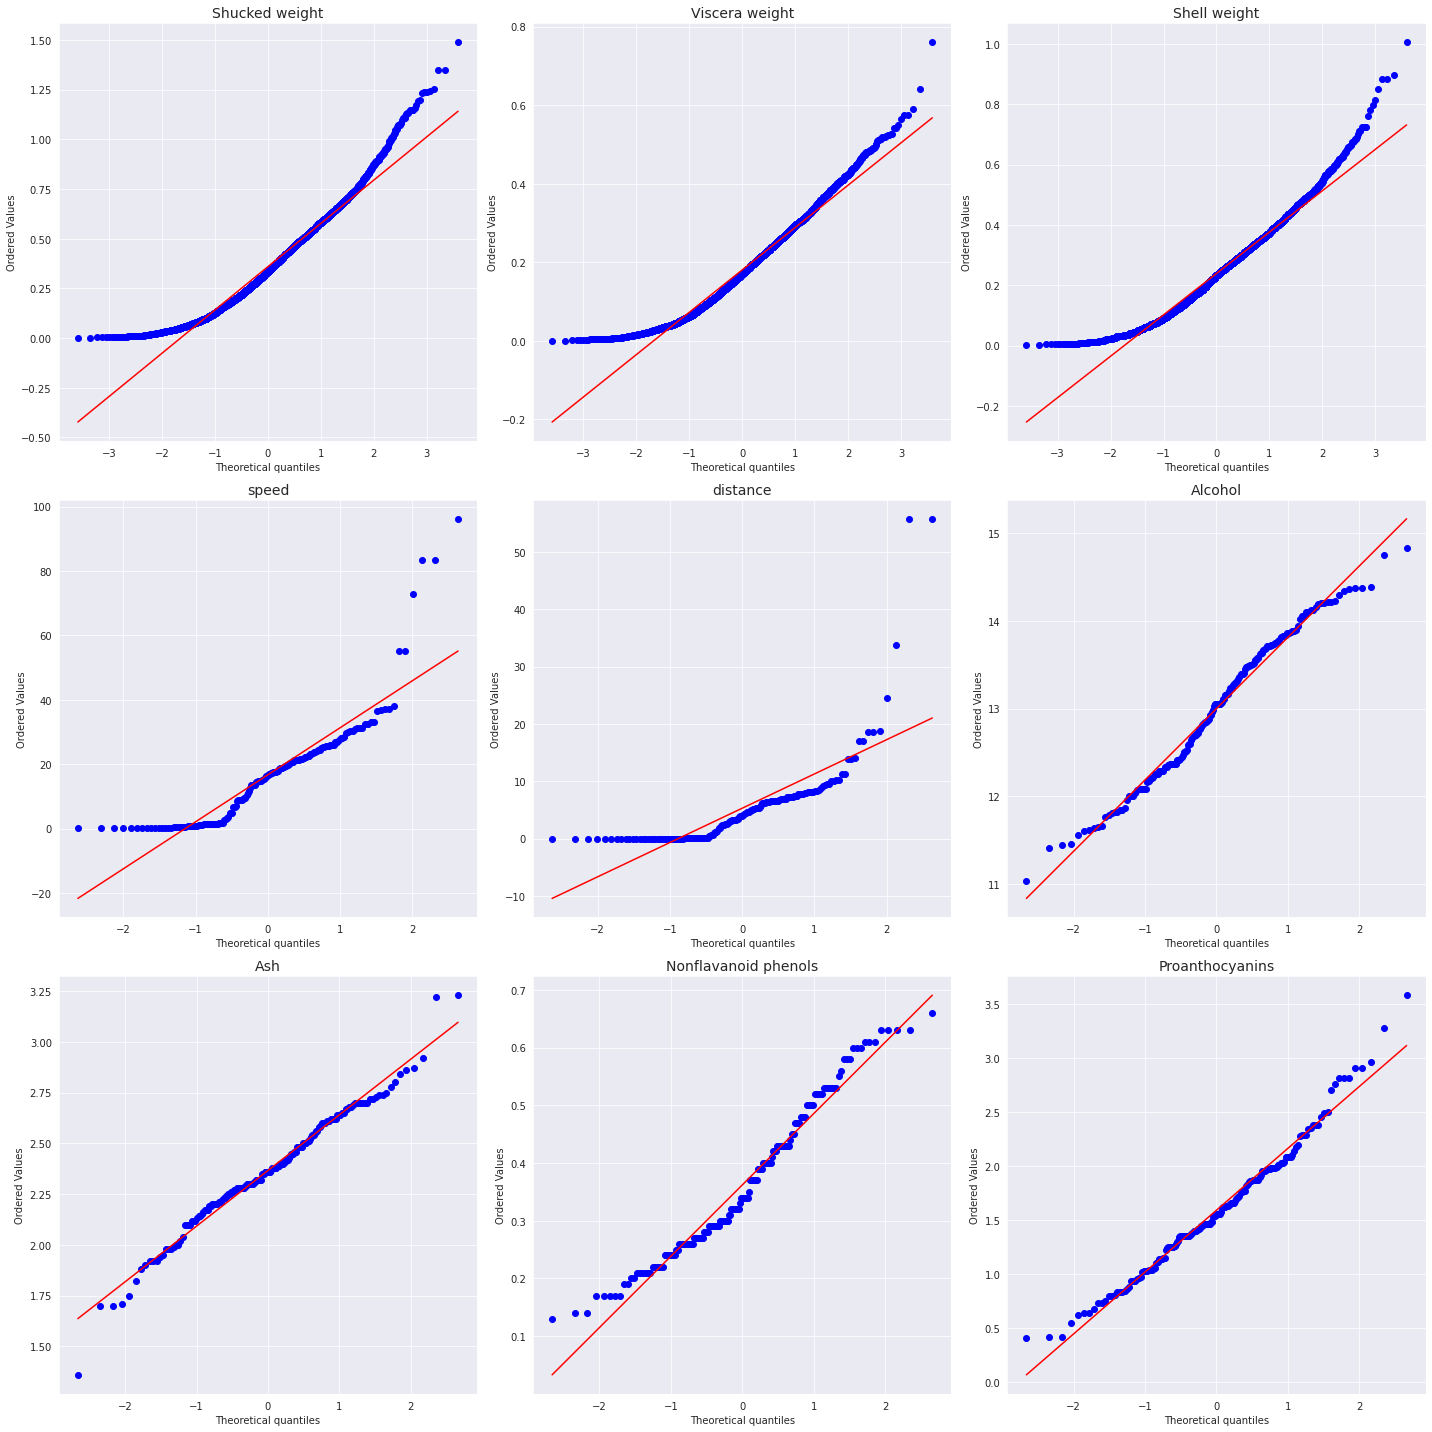

In [102]:
with sns.axes_style('darkgrid'):
  plt.figure(figsize=(20, 20))
  plt.title('Q-Q plots', fontsize=20)
  for ind, samp in enumerate(samples):
      plt.subplot(3, 3, ind + 1)
      sps.probplot(x=samp, plot=plt)
      plt.title(samples_names[ind], fontsize=14)

  plt.tight_layout()

Вообще явно просвечиваются выборки для которых я бы отклонила гипотезу о нормальности.

Я буду использовать метод Бенжамина-Иекутели который контролирует FDR на требуемом уровне - ибо у нас нет информации о зависимостях статистик

Ответ на вопрос по поводу Хохберга - требует независимости статистик, которую мы не можем гарантировать и нам лень проверять (и скорее всего они зависимы ибо distance ~ speed)

Возьмем те же 5 критериев что и в 3 задаче

In [122]:
pval_sh = [sps.shapiro(samp)[1] for samp in samples]
pval_normaltest = [sps.normaltest(samp)[1] for samp in samples]
pval_lil = [lilliefors(samp)[1] for samp in samples]
pval_ad = [normal_ad(samp)[1] for samp in samples]

pval_cram = []
for samp in samples:
  params = sps.fit(sps.norm, samp, bounds=[(-7, 7), (0.1, 10)]).params
  pval_cram.append(sps.cramervonmises(samp, cdf=sps.norm(*params).cdf).pvalue)

p_vals = [pval_sh, pval_normaltest, pval_lil, pval_ad, pval_cram]

In [123]:
p_vals[0]

[9.36098990030857e-32,
 1.774917175594725e-29,
 1.568114549655691e-28,
 5.222460918580252e-13,
 4.079941709386512e-19,
 0.020050711929798126,
 0.038691021502017975,
 0.00010552681487752125,
 0.01445252075791359]

In [124]:
pv = []
for i in range(len(samples)):
  h = [p_vals[j][i] for j in range(5)]
  pv.append(h)

df_pv = pd.DataFrame(pv, index=samples_names, columns=['Шапиро-Уилк', 'Типа харке-бера', 'Лиллиефорс', 'Андерсон', 'Крамер'])
df_pv

,Шапиро-Уилк,Типа харке-бера,Лиллиефорс,Андерсон,Крамер
Shucked weight,9.360990e-32,7.525933e-73,0.001000,0.000000e+00,2.217919e-09
Viscera weight,1.774917e-29,8.578998e-47,0.001000,0.000000e+00,1.065072e-08
Shell weight,1.568115e-28,1.988400e-57,0.001000,0.000000e+00,3.358072e-06
speed,5.222461e-13,7.695284e-19,0.001000,1.174235e-12,3.922230e-10
distance,4.079942e-19,2.341622e-38,0.001000,0.000000e+00,6.119120e-06
Alcohol,2.005071e-02,3.416320e-04,0.058382,9.931996e-03,1.555260e-08
Ash,3.869102e-02,3.631602e-02,0.186504,7.521318e-02,5.961218e-01
Nonflavanoid phenols,1.055268e-04,2.664703e-03,0.001000,1.557113e-05,8.339579e-02
Proanthocyanins,1.445252e-02,8.000813e-03,0.216578,6.658739e-02,5.967434e-01


In [126]:
mpt_dt = multipletests(df_pv.values.ravel(), method='fdr_by')[1]
mpt_dt = mpt_dt.reshape((-1,5))
mpt = pd.DataFrame(mpt_dt, index=samples_names, columns=['Шапиро-Уилк', 'Типа харке-бера', 'Лиллиефорс', 'Андерсон', 'Крамер'])

mpt

,Шапиро-Уилк,Типа харке-бера,Лиллиефорс,Андерсон,Крамер
Shucked weight,2.057053e-30,2.976848e-71,0.006592,0.000000e+00,2.580258e-08
Viscera weight,3.510301e-28,2.423845e-45,0.006592,0.000000e+00,1.170234e-07
Shell weight,2.819365e-27,6.554186e-56,0.006592,0.000000e+00,3.320674e-05
speed,7.377572e-12,1.170705e-17,0.006592,1.548210e-11,4.848187e-09
distance,6.724175e-18,5.788860e-37,0.006592,0.000000e+00,5.762831e-05
Alcohol,1.132995e-01,2.815228e-03,0.303853,5.952355e-02,1.618883e-07
Ash,2.068115e-01,1.995088e-01,0.878224,3.718778e-01,1.000000e+00
Nonflavanoid phenols,9.074052e-04,1.700017e-02,0.006592,1.399792e-04,4.022783e-01
Proanthocyanins,8.406805e-02,4.944819e-02,0.996120,3.376709e-01,1.000000e+00


In [127]:
alpha = 0.05
rej = (mpt <  alpha)
rej

,Шапиро-Уилк,Типа харке-бера,Лиллиефорс,Андерсон,Крамер
Shucked weight,True,True,True,True,True
Viscera weight,True,True,True,True,True
Shell weight,True,True,True,True,True
speed,True,True,True,True,True
distance,True,True,True,True,True
Alcohol,False,True,False,False,True
Ash,False,False,False,False,False
Nonflavanoid phenols,True,True,True,True,False
Proanthocyanins,False,True,False,False,False


Для каких признаков нормальность не отвергается?

Получается мы не отвергаем гипотезу о нормальности только для признака Ash который я собственно и рассматривала в 3 задаче и хорошо что мы не пришли к противоречию